In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [4]:
# ## Set 2
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


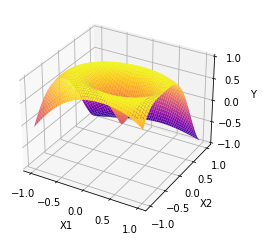

In [5]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

### Developing shift based istereographic

In [7]:
def istereographic_mag(x):
    '''
    The output is -1 if the center and input are similar
    make sure to negate the value for similarity
    '''
    sqnorm = (x**2).sum(dim=-1, keepdim=True) ## l2 norm squared
    sqnorm = sqnorm**0.5
    
#     sqnorm = sqnorm/torch.sqrt(sqnorm.var(dim=1, keepdim=True)+1e-12)

    new_dim = -(sqnorm-1)/(sqnorm+1)
    return new_dim
#     torch.exp(-(sqnorm.abs())+self.scaler)

class iStereographicShiftTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, bias=True, normalize=False):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.normalize = normalize
        self.inp_scaler = nn.Parameter(torch.Tensor([1/np.sqrt(self.input_dim)]))
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        
    def forward(self, x):
#         if self.normalize:
#             self.linear.weight.data /= self.linear.weight.data.norm(p=2, dim=1, keepdim=True)
        ### linear has weight -> (outdim, indim) format, so normalizing per output dimension
#         print(self.linear.weight.data.norm(dim=1))
        
#         x = x*self.inp_scaler
        
        z = x.unsqueeze(1) - self.centers.unsqueeze(0)
#         print(z.shape, x.shape, self.centers.shape)
        dists = istereographic_mag(z).squeeze(-1)
    
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-12)
#         print(dists.shape)
        
#         x = istereographic(x)
#         x = self.linear(x)
        if self.bias is not None: dists = dists+self.bias
        return dists

In [8]:
def istereographic(x):
    sqnorm = (x**2).sum(dim=1, keepdim=True)**0.5 ## l2 norm
    x = x*2/(sqnorm+1)
    new_dim = (sqnorm-1)/(sqnorm+1)
    x = torch.cat((x, new_dim), dim=1)
    return x

class iStereographicLinearTransform2(nn.Module):
    
    def __init__(self, input_dim, num_centers, bias=True, normalize=False):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.inp_scaler = nn.Parameter(torch.Tensor([1/np.sqrt(self.input_dim)]))
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        
    def forward(self, x):
#         x = dtnn.istereographic(x*self.inp_scaler)
#         w = dtnn.istereographic(self.centers*self.inp_scaler)
        x = istereographic(x*self.inp_scaler)
        w = istereographic(self.centers*self.inp_scaler)

        x = F.linear(x, w, self.bias)
        return x

In [9]:
# iStereographicShiftTransform = dtnn.iStereographicLinearTransform
# iStereographicShiftTransform = iStereographicLinearTransform2

In [10]:
t = iStereographicShiftTransform(2, 5)

In [11]:
t(torch.randn(7, 2)).shape

torch.Size([7, 5])

In [12]:
t(torch.randn(7, 2))

tensor([[-0.5695, -0.5938, -0.1731, -0.4191, -0.4791],
        [-0.2987, -0.2603, -0.5926, -0.5665, -0.4534],
        [-0.3917, -0.4180, -0.5866, -0.4329, -0.0100],
        [-0.6174, -0.6119, -0.7233, -0.7201, -0.6711],
        [-0.3790, -0.3398, -0.6227, -0.5912, -0.4982],
        [ 0.2064,  0.1924, -0.4661, -0.4398, -0.1987],
        [-0.8276, -0.8317, -0.8472, -0.8581, -0.8394]], grad_fn=<AddBackward0>)

In [13]:
# class FunctionDT(nn.Module):
    
#     def __init__(self, input_dim, num_centers, func, inv_temp=0.):
#         '''
#         func [input_dim -> 1]
#         '''
#         super().__init__()
#         self.input_dim = input_dim
#         self.num_centers = num_centers
#         self.func = func
        
#         self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
#         self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = nn.Parameter(self.centers)
    
#     def forward(self, x):
#         z = x.unsqueeze(1) - self.centers.unsqueeze(0)
#         dists = self.func(z).squeeze(-1)
#         return dists

## Building 2D model

In [14]:
class LocalMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = iStereographicShiftTransform(self.input_dim, self.hidden_dim, bias=True)

#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [15]:
model = LocalMLP(2, 10, 1).to(device)

In [16]:
model

LocalMLP(
  (layer0): iStereographicShiftTransform()
  (activ): OneActiv()
  (layer1): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
yout = model.forward(xx)
xx.shape, yout.shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.7255253791809082
200 Error =  0.08856681734323502
400 Error =  0.014768562279641628
600 Error =  0.007416718173772097
800 Error =  0.005837405566126108
1000 Error =  0.00514704454690218
1200 Error =  0.004656536038964987
1400 Error =  0.004331991542130709
1600 Error =  0.004144768696278334
1800 Error =  0.0040364558808505535
2000 Error =  0.003950422629714012
2200 Error =  0.003912994638085365
2400 Error =  0.0038904964458197355
2600 Error =  0.0038757126312702894
2800 Error =  0.0038654429372400045
3000 Error =  0.0038567497394979
3200 Error =  0.0038529124576598406
3400 Error =  0.003851158544421196
3600 Error =  0.003852288005873561
3800 Error =  0.0038511306047439575
4000 Error =  0.0038510779850184917
4200 Error =  0.0038505508564412594
4400 Error =  0.0038514912594109774
4600 Error =  0.0038515781052410603
4800 Error =  0.003850710578262806


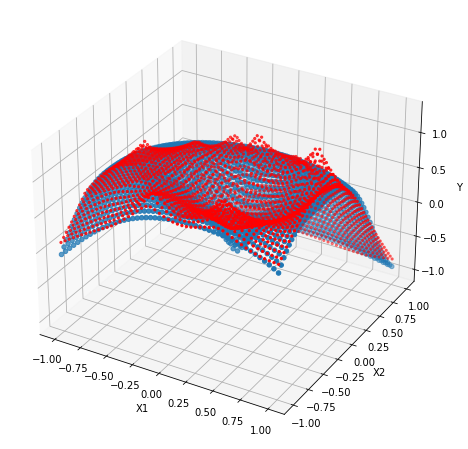

In [19]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [20]:
yout.shape, Y.shape

(torch.Size([2500, 1]), (50, 50))

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


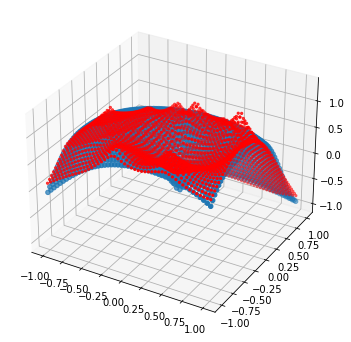

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

## Softmax based similarity 

In [22]:
class LocalMLPsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = iStereographicShiftTransform(self.input_dim, self.hidden_dim, bias=True)
    
    
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = nn.LogSoftmax(dim=-1)
        self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [23]:
model = LocalMLPsoftmax(2, 10, 1)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  0.7550325393676758
200 Error =  0.03734331205487251
400 Error =  0.015149025246500969
600 Error =  0.010302252136170864
800 Error =  0.007418329827487469
1000 Error =  0.005851659923791885
1200 Error =  0.005022361874580383
1400 Error =  0.004542339127510786
1600 Error =  0.004231508355587721
1800 Error =  0.00394267775118351
2000 Error =  0.0036649825051426888
2200 Error =  0.0034544472582638264
2400 Error =  0.003322808537632227
2600 Error =  0.003234228817746043
2800 Error =  0.00318130012601614
3000 Error =  0.0031458153389394283
3200 Error =  0.0031206184066832066
3400 Error =  0.003102759597823024
3600 Error =  0.0030901124700903893
3800 Error =  0.0030804118141531944
4000 Error =  0.003072555409744382
4200 Error =  0.003065101569518447
4400 Error =  0.0030571313109248877
4600 Error =  0.003049526596441865
4800 Error =  0.0030437284149229527


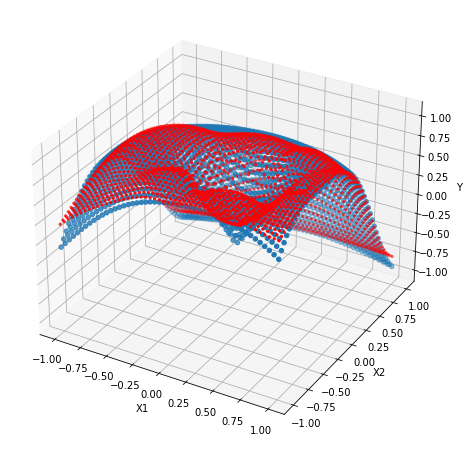

In [25]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

## Random Initialization with Softmax-10

In [26]:
H = 100
model = LocalMLPsoftmax(2, H, 1)

In [27]:
randidx = torch.randperm(len(xx))[:H]
model.layer0.centers.data = xx[randidx] 
model.layer1.weight.data = yy[randidx].t()

In [28]:
model.layer1.bias.data *= 0.

In [29]:
yout = model(xx)
loss = criterion(yout, yy)
loss

tensor(0.0114, grad_fn=<MseLossBackward>)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


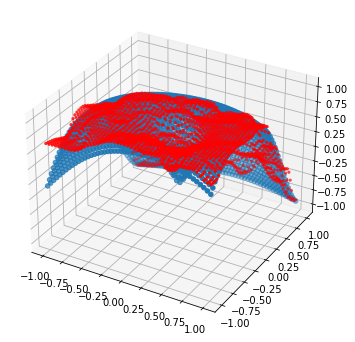

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

## 1. Classification

In [31]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

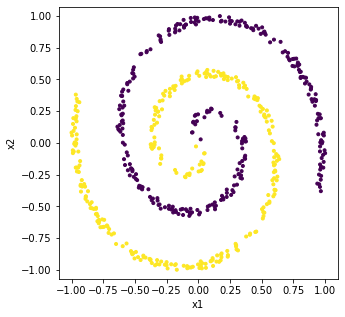

In [32]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [33]:
xx, yy = xx.to(device), yy.to(device)

In [34]:
H = 20
model = LocalMLPsoftmax(2, H, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.92, Loss:0.621637225151062
Epoch: 199, Acc:0.95, Loss:0.5619597434997559
Epoch: 299, Acc:0.98, Loss:0.5109642148017883
Epoch: 399, Acc:0.99, Loss:0.4695992171764374
Epoch: 499, Acc:1.00, Loss:0.42729541659355164
Epoch: 599, Acc:1.00, Loss:0.38866037130355835
Epoch: 699, Acc:1.00, Loss:0.35899618268013
Epoch: 799, Acc:1.00, Loss:0.3338015377521515
Epoch: 899, Acc:1.00, Loss:0.31125015020370483
Epoch: 999, Acc:1.00, Loss:0.2913350462913513


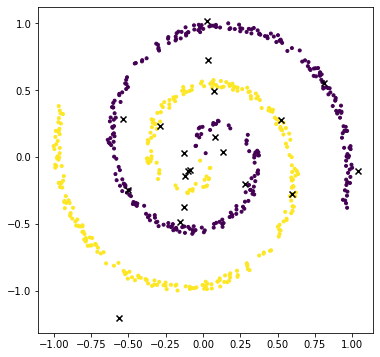

Epoch: 1099, Acc:1.00, Loss:0.27335768938064575
Epoch: 1199, Acc:1.00, Loss:0.2569516599178314
Epoch: 1299, Acc:1.00, Loss:0.24191737174987793
Epoch: 1399, Acc:1.00, Loss:0.22804976999759674
Epoch: 1499, Acc:1.00, Loss:0.21528759598731995
Epoch: 1599, Acc:1.00, Loss:0.2034849226474762
Epoch: 1699, Acc:1.00, Loss:0.19252623617649078
Epoch: 1799, Acc:1.00, Loss:0.18230979144573212
Epoch: 1899, Acc:1.00, Loss:0.17281407117843628
Epoch: 1999, Acc:1.00, Loss:0.163908913731575


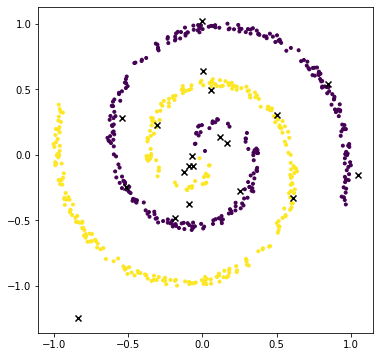

Epoch: 2099, Acc:1.00, Loss:0.1556248813867569
Epoch: 2199, Acc:1.00, Loss:0.1478709727525711
Epoch: 2299, Acc:1.00, Loss:0.1406041830778122
Epoch: 2399, Acc:1.00, Loss:0.13377922773361206
Epoch: 2499, Acc:1.00, Loss:0.1273677796125412
Epoch: 2599, Acc:1.00, Loss:0.12133356928825378
Epoch: 2699, Acc:1.00, Loss:0.11564850062131882
Epoch: 2799, Acc:1.00, Loss:0.11028343439102173
Epoch: 2899, Acc:1.00, Loss:0.1052188128232956
Epoch: 2999, Acc:1.00, Loss:0.1004234328866005


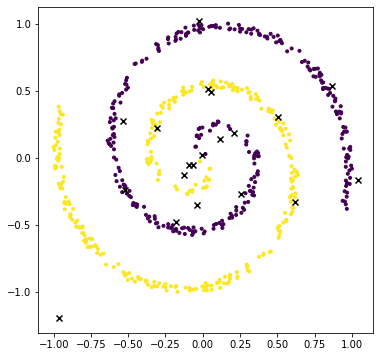

Epoch: 3099, Acc:1.00, Loss:0.09589474648237228
Epoch: 3199, Acc:1.00, Loss:0.09160768985748291
Epoch: 3299, Acc:1.00, Loss:0.0875481441617012
Epoch: 3399, Acc:1.00, Loss:0.08369341492652893
Epoch: 3499, Acc:1.00, Loss:0.08003969490528107
Epoch: 3599, Acc:1.00, Loss:0.0765710175037384
Epoch: 3699, Acc:1.00, Loss:0.07327879220247269
Epoch: 3799, Acc:1.00, Loss:0.07014764100313187
Epoch: 3899, Acc:1.00, Loss:0.06717143952846527
Epoch: 3999, Acc:1.00, Loss:0.06434136629104614


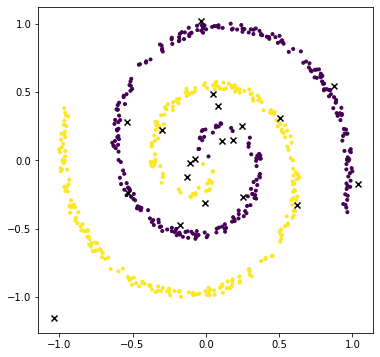

Epoch: 4099, Acc:1.00, Loss:0.06164756789803505
Epoch: 4199, Acc:1.00, Loss:0.059079285711050034
Epoch: 4299, Acc:1.00, Loss:0.056632544845342636
Epoch: 4399, Acc:1.00, Loss:0.054298222064971924
Epoch: 4499, Acc:1.00, Loss:0.052071984857320786
Epoch: 4599, Acc:1.00, Loss:0.0499480701982975
Epoch: 4699, Acc:1.00, Loss:0.047918934375047684
Epoch: 4799, Acc:1.00, Loss:0.045981526374816895
Epoch: 4899, Acc:1.00, Loss:0.044130418449640274
Epoch: 4999, Acc:1.00, Loss:0.04236042499542236


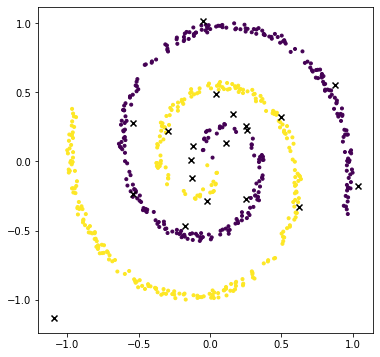

In [35]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

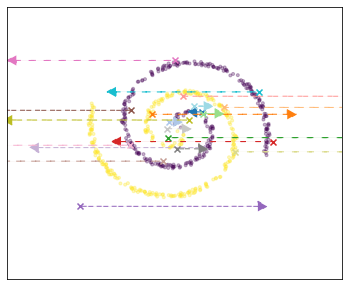

In [36]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

## epsilon-Softmax neuron

In [37]:
class EpsilonSoftmax(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self, dim=-1, epsilon:float=0.1, maxima_above_epsilon:bool=True):
        super().__init__()
        self.dim= dim
        self.epsilon = epsilon
        self.sign = 1
        if not maxima_above_epsilon:
            self.sign = -1
            
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
#         return torch.log_softmax(
        return torch.softmax(
            torch.cat([self.sign*x, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=self.dim), 
            dim=self.dim)#[:, :-1]

In [38]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = iStereographicShiftTransform(self.input_dim, self.hidden_dim, bias=True)
    
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = EpsilonSoftmax(dim=-1, epsilon=epsilon)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

#### Random Init

In [39]:
H = 10
model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=0.3)
model

LocalMLP_epsilonsoftmax(
  (layer0): iStereographicShiftTransform()
  (scale_shift): ScaleShift()
  (softmax): EpsilonSoftmax()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [40]:
randidx = torch.randperm(len(xx))[:H]

In [41]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.621431291103363, 0.5233333110809326)

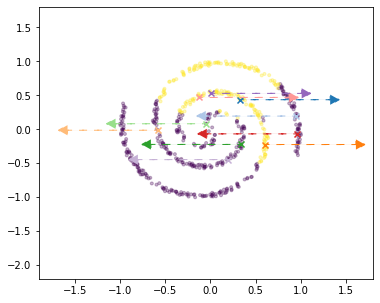

In [42]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [43]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

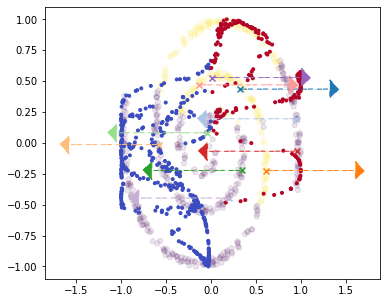

In [44]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [45]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    return xo

In [46]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 11])
tensor([0.0542, 0.0448, 0.0513, 0.1256, 0.0401, 0.0479, 0.0423, 0.0643, 0.0547,
        0.0653, 0.4096]) 
  tensor([0.1801, 0.1788, 0.1942, 0.2590, 0.1570, 0.1522, 0.1839, 0.1820, 0.1616,
        0.1896, 0.3534])
tensor([5.6131e-07, 1.9809e-07, 5.3323e-07, 1.8093e-07, 9.9472e-07, 9.5438e-07,
        1.8749e-07, 3.9699e-07, 3.6518e-07, 2.9665e-07, 6.0965e-05]) 
  tensor([0.9999, 0.9993, 0.9996, 0.9999, 0.9998, 0.9999, 0.9990, 0.9948, 0.9956,
        0.9998, 0.9677])


In [47]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [48]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

torch.Size([1000, 1000, 11])

(1000, 1000)


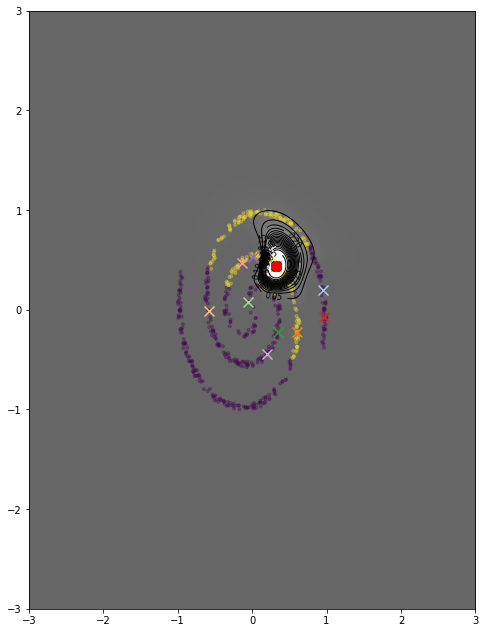

(1000, 1000)


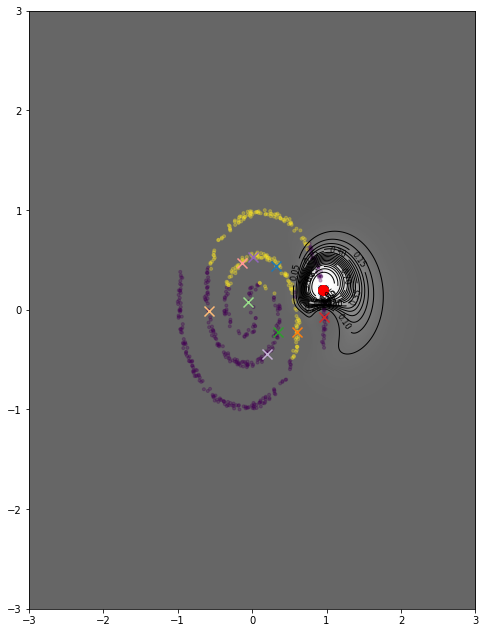

(1000, 1000)


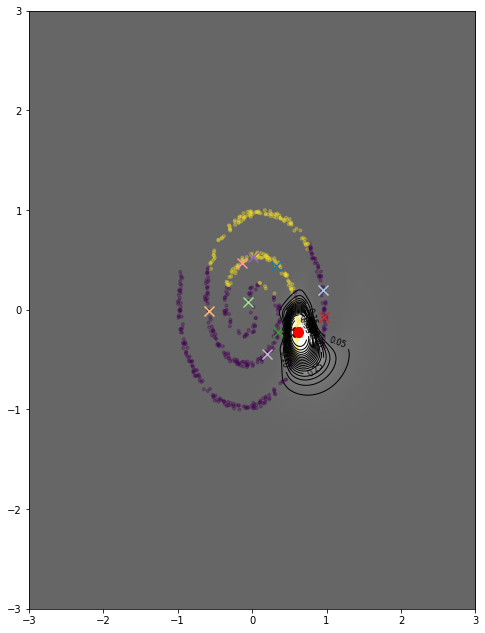

(1000, 1000)


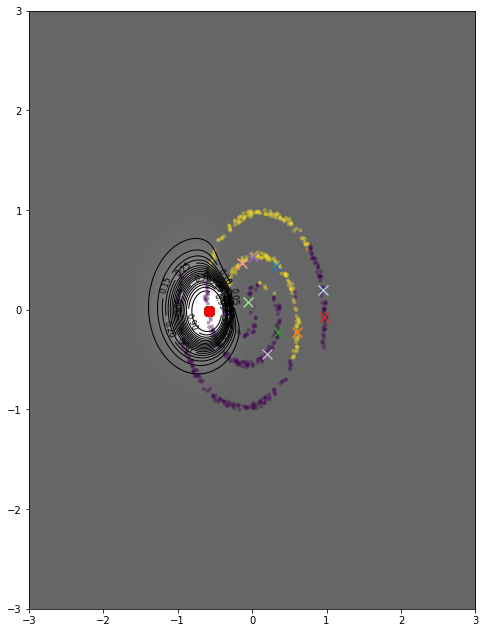

(1000, 1000)


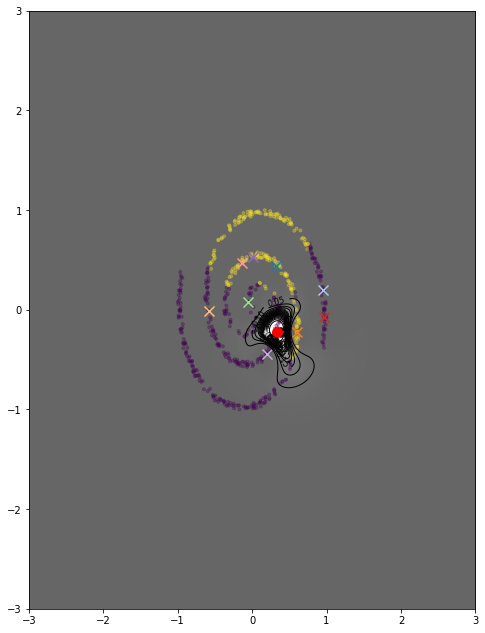

(1000, 1000)


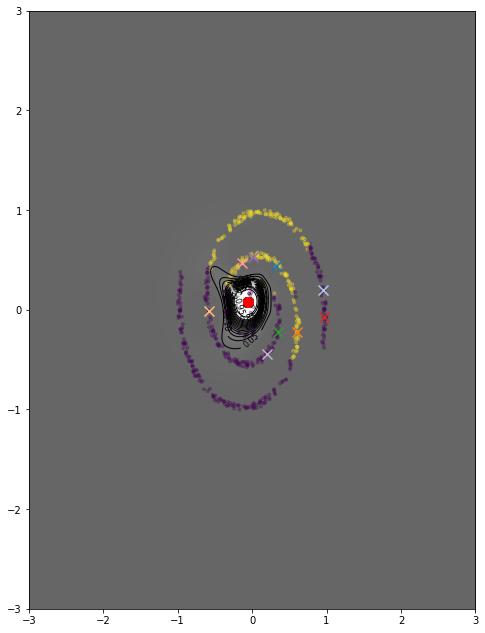

(1000, 1000)


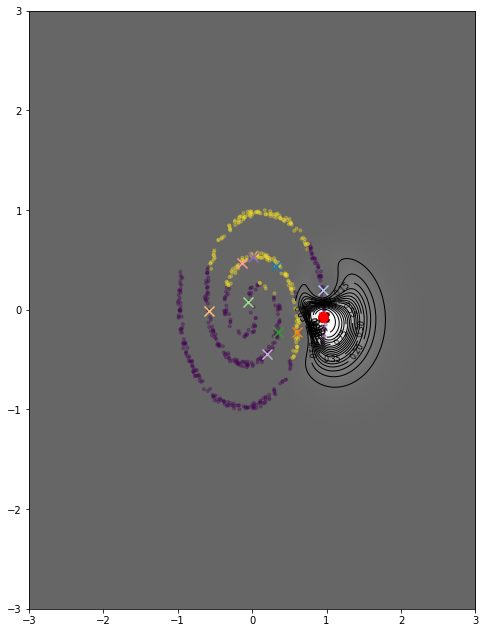

(1000, 1000)


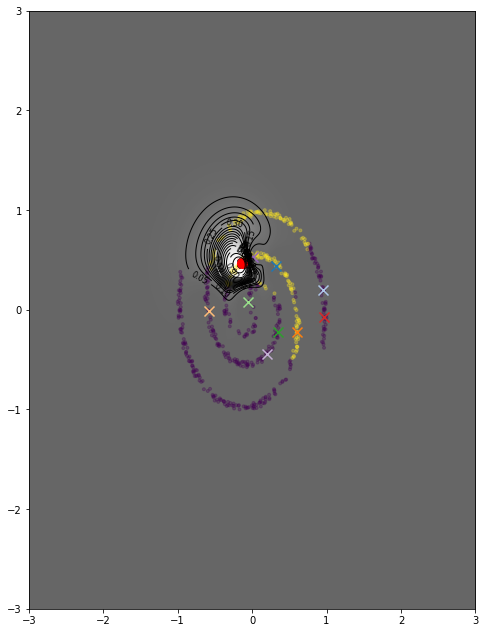

(1000, 1000)


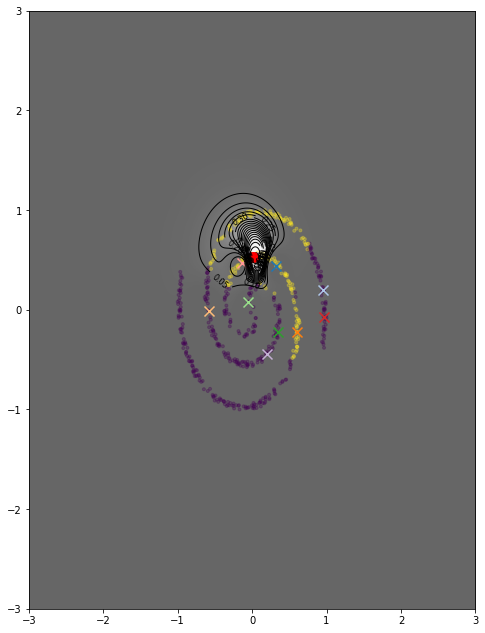

(1000, 1000)


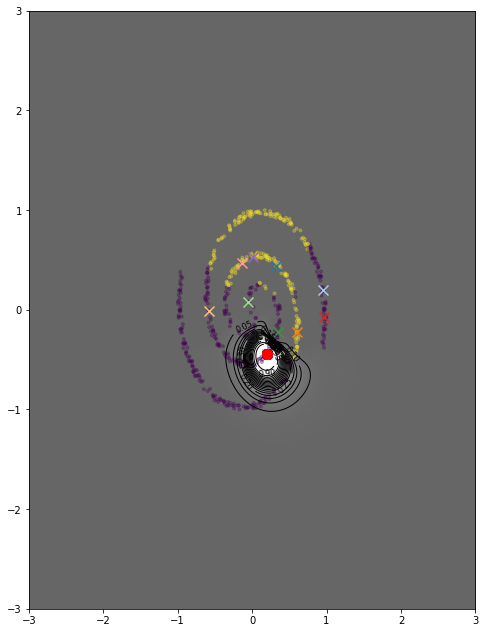

(1000, 1000)


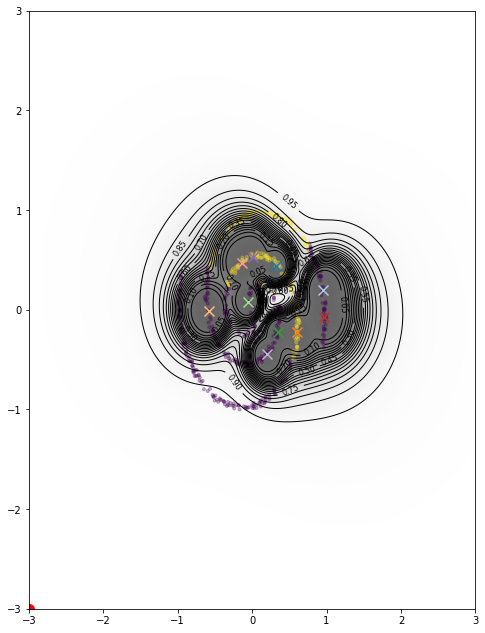

In [49]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [50]:
model

LocalMLP_epsilonsoftmax(
  (layer0): iStereographicShiftTransform()
  (scale_shift): ScaleShift()
  (softmax): EpsilonSoftmax()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [51]:
"""
- iStereographic does not produce maxima at the center.
"""

'\n- iStereographic does not produce maxima at the center.\n'